In [1]:
import Pkg; Pkg.activate(joinpath(@__DIR__,".")); Pkg.instantiate();
using LinearAlgebra;
using Plots;
using StaticArrays;
using ForwardDiff;
using RobotZoo;
using RobotDynamics;
using MeshCat;
using TrajOptPlots;
using MathOptInterface;
const MOI = MathOptInterface

 Activating environment at `C:\Users\brand\OneDrive\Documents\College Stuff\16-745\final-project\Project.toml`


MathOptInterface

We know the dynamics are of the following:
            $$q = \begin{bmatrix}
                  x_{foot}    \\
                  y_{foot}   \\
                  \alpha \\
                  \beta  \\
                  \end{bmatrix}$$
where $\alpha$ is the top revolute joint and $\beta$ is the middle revolute joint
And normally for a single dynamics phase,
$$ dx = \delta_{(x, 1)} f_{1}(x, u) + \delta_{(x, 2)} f_{2}(x, u)$$

which is pretty much a guard function.

           
           
           
           
           

In [32]:
struct Hopper
    ml
    mh
    l
    la
    lb
    function Hopper(ml, mh, l, la, lb)
        new(ml, mh, l, la, lb)
    end
end


function get_q_double_dot(hopper, x, u, ballistic)
    ml = hopper.ml
    mh = hopper.mh
    l = hopper.l
    a = hopper.la
    b = hopper.lb
    
    # q = x[1:4]
    ξ = x[1]
    η = x[2]
    α = x[3]
    β = x[4]
    
    # qdot = x[5:8]
    ξdot = x[5]
    ηdot = x[6]
    αdot = x[7]
    βdot = x[8]
    # println(η)
    
    g = 9.81
    
    if (ballistic)
        # Mass matrix
        m11 = mh + 2 *ml
        m12 = 0
        m13 = -mh*l*sin(α) - ml*(a*sin(α)+l*sin(α) + b*sin(α+β))
        m14 = -ml*b*sin(α+β)
        
        m23 = mh*l*cos(α) + ml*(a*cos(α)+l*cos(α)+b*cos(α+β))
        m24 = ml*b*cos(α+β)
        m33 = mh*l^2 + ml*(a^2+b^2+l^2+2*b*l*cos(β))
        m34 = ml*b*(b+l*cos(β))
        m44 = ml*b^2
        
        M = [m11 m12 m13 m14        
             m12 m11 m23 m24
             m13 m23 m33 m34
             m14 m24 m34 m44]
        
        # Gravitational effects + velocity
        n1 = -(mh*l+ml*a+ml*l)*cos(α)*αdot^2 - ml*b*cos(α+β)*(αdot+βdot)^2
        n2 = -(mh*l+ml*a+ml*l)*sin(α)*αdot^2 - ml*b*sin(α+β)*(αdot+βdot)^2 + mh*g + 2*ml*g
        n3 = -ml*b*l*sin(β)*(βdot^2+αdot*βdot) + (mh*l+ml*a+ml*l)*g*cos(α) + ml*b*g*cos(α+β)
        n4 = ml*b*l*sin(β)*αdot^2 + ml*b*g*cos(α+β)
        n = [n1; n2; n3; n4]
        
        # Accelerations
        qdd = M \ ([0; 0; u] .- n)
        
    else
        # Mass matrix
        m11 = mh*l^2 + ml*(a^2+b^2+l^2+2*b*l*cos(β))
        m12 = ml*b*(b+l*cos(β))
        m22 = ml*b^2
        M = [m11 m12
             m12 m22]
        
        # Combined velocity and acceleration
        n1 = -ml*b*l*sin(β)*(βdot^2+2*αdot*βdot) + (mh*l+ml*a+ml*l)*g*cos(α) + ml*b*g*cos(α+β)
        n2 = ml*b*l*sin(β)*αdot^2 + ml*b*g*cos(α+β)
        n = [n1; n2]
        
        # Friction
        c = 1.0
        C = [c*αdot; c*βdot]
    
        qdd = M \ (u .- n .- C)
       
        qdd = [0; 0; qdd]
        
    end
    return qdd
end
        

function discrete_dynamics_hop(hopper, x, u, ballistic)
    # assuming x is of the form [q; qdot]
    qdot = x[5:8]
    qdd = get_q_double_dot(hopper, x, u, ballistic)
    # println(qdd)
    return [qdot; qdd]
end


function jump_map(x)
    xn = [x[1:4]; 0.0; 0.0; x[7:8]]
    return xn
end


function rk4_dynamics(hopper, x::AbstractVector{T}, u::AbstractVector{T}, ballistic, h) where T
    k1 = discrete_dynamics_hop(hopper, x, u, ballistic)
    k2 = discrete_dynamics_hop(hopper, x+0.5*h*k1, u, ballistic)
    k3 = discrete_dynamics_hop(hopper, x+0.5*h*k2, u, ballistic)
    k4 = discrete_dynamics_hop(hopper, x+h*k3, u, ballistic)
    # println("K1", k1)
    # println("K2", k2)
    # println("K3", k3)
    # println("K4", k4)
    
    return x .+ (h/6.0) * (k1+2*k2+2*k3+k4)
    # return (x + (h/6) * (k1+2*k2+2*k3+k4)
    # return nothing
end


function rk4_dynamics!(hopper, x, u, ballistic, h)
    k1 = discrete_dynamics_hop(hopper, x, u, ballistic)
    k2 = discrete_dynamics_hop(hopper, x+0.5*h*k1, u, ballistic)
    k3 = discrete_dynamics_hop(hopper, x+0.5*h*k2, u, ballistic)
    k4 = discrete_dynamics_hop(hopper, x+h*k3, u, ballistic)
    # println("K1", k1)
    # println("K2", k2)
    # println("K3", k3)
    # println("K4", k4)
    
    x .= x .+ (h/6.0) * (k1+2*k2+2*k3+k4)
    # return (x + (h/6) * (k1+2*k2+2*k3+k4)
    # return nothing
end


function foot_coords(hopper, x)
    l = hopper.l
    
    e = x[1]
    n = x[2]
    a = x[3]
    b = x[4]
    
    edot = x[5]
    ndot = x[6]
    adot = x[7]
    bdot = x[8]
    
    
    T = zeros(eltype(x), length(x))
    # println(typeof(T))
    T[1] = e + l*cos(a) + l*cos(a + b)
    T[2] = n + l*sin(a) + l*sin(a + b)
    T[3] = a + b - pi
    T[4] = 2*pi - b
    T[5] = edot + l*cos(a)*adot + l*cos(a+b)*(adot+bdot)
    T[6] = ndot - l*sin(a)*adot - l*sin(a+b)*(adot+bdot)
    T[7] = adot + bdot
    T[8] = -bdot
    return T
end


foot_coords (generic function with 1 method)

In [3]:
# Test the foot coords. The description for both is from the vertical
begin
    x0 = [0.0; 0.0; pi/4; -pi/2; 0.0; 0.0; 0.0; 0.0]
    hopper = Hopper(5, 10, 1, 0.5, 0.5)
    fx = foot_coords(hopper, x0)
    regCoords = foot_coords(hopper, fx)
    println(fx)
    # 3 println(regCoords)
end

[1.4142135623730951, 0.0, -3.9269908169872414, 7.853981633974483, 0.0, 0.0, 0.0, -0.0]


## Stance and flight test with random control input

In [4]:
# Stance and flight test
begin
    x0 = [0; 0; 3*pi/4; -pi/2; 0; 0; 0; 0]
    # u0 = 2
    h = 0.1
    hopper = Hopper(1, 2, 1, 0.5, 0.5)
    T = 40
    modes = zeros(T)
    
    m = 1
    change = 1
    for i = 1:T
        modes[i] = m
        if mod(i, 5) == 0
            m += change
            # println("flop")
            change = change * -1
        end
    end      
        
    Xs = zeros(T, 8)
    println("Begin")
    Fxs = zeros(T, 8)
    x = x0
    # println(x)
    Xs[1, :] .= x0
    u = [0.0; 0.0]
    for i = 2:T
        if modes[i] == 1
            if mod(i, 5) == 0
                x[5:6] .= 0.0
            end
            u = [0.0; 0.0]
            rk4_dynamics!(hopper, x, u, false, h)
        else
            # println("Flying")
            u = [0.0; 0.0]
            rk4_dynamics!(hopper, x, u, true, h)
            # println("flight")
        end 
        Xs[i, :] .= x
        Fxs[i, :] .= foot_coords(hopper, x)
    end
    ths = [SVector{4}([Xs[i, 3]; Xs[i, 4]; Xs[i, 7]; Xs[i, 8]]) for i = 1:T]
    TrajOptPlots.set_mesh!(vis, a)
    visualize!(vis, a, T*h, ths)
    plot(Ths[:, 1:2])
    plot(Xs[:, 1])
    plot!(Fxs[:, 2])
end

Begin


LoadError: UndefVarError: vis not defined

## Equilibrium Point Test

In [5]:
function equilibrium(hopper, x, uguess, ballistic, params)
    ueq = copy(uguess)
    λ = zeros(2)
    
    c = discrete_dynamics_hop(hopper, x0, ueq, false)[params]
    dfdb = ForwardDiff.jacobian(u->discrete_dynamics_hop(hopper, x0, u, ballistic), ueq)
    reldb = dfdb[params, :]
    gradb = (ueq - uguess) + reldb' * λ
    kkt_vec = [gradb; c]
    tol = 1e-4
    count = 1
    limit = 25
    
    while (norm(kkt_vec) > tol) && (count < limit)
        kkt_mat = [I(2)    reldb';
                   reldb   zeros(2, 2)]
        kkt_mat = kkt_mat .+ Diagonal([ones(2); -ones(2)])*1e-4
        deltas = -kkt_mat \ kkt_vec

        delU = deltas[1:length(uguess)]
        delλ = deltas[length(uguess)+1:end]
    
        ueq = ueq + delU
        λ = λ + delλ
        c = discrete_dynamics_hop(hopper, x0, ueq, false)[params]
        dfdb = ForwardDiff.jacobian(u->discrete_dynamics_hop(hopper, x0, u, false), ueq)
        reldb = dfdb[params, :]
        gradb = (ueq - uguess) + reldb' * λ
        kkt_vec = [gradb; c]
        count = count + 1
        # println(norm(kkt_vec))
    end
    # println(ueq)
    return ueq
end

equilibrium (generic function with 1 method)

## Testing Acrobot vs the Compass Gait  Dynamics

In [6]:
function dynamics_rk4(a,x,u,h)
    #RK4 integration with zero-order hold on u
    f1 = dynamics(a, x, u)
    f2 = dynamics(a, x + 0.5*h*f1, u)
    f3 = dynamics(a, x + 0.5*h*f2, u)
    f4 = dynamics(a, x + h*f3, u)
    return x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
end

dynamics_rk4 (generic function with 1 method)

In [7]:
# Start MeshCat
vis = Visualizer()
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8700
└ @ MeshCat C:\Users\brand\.julia\packages\MeshCat\GlCMx\src\visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()), Set{Any}(), ip"127.0.0.1", 8700))

## Equilibrium point testing and visualization

Begin
[0.0, 0.0, 2.356194490192345, -1.5707963267948966, 0.0, 0.0, 0.0, 0.0]


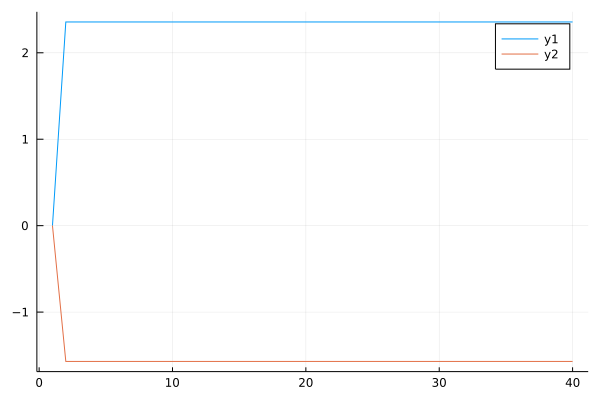

In [8]:
# Acrobot performance vs the Hopper: Acrobot version
begin
    x0 = [0.0; 0.0; 3*pi/4; -pi/2; 0; 0; 0; 0]
    a = RobotZoo.Acrobot()
    # u0 = 2
    h = 0.05
    hopper = Hopper(1, 2, 1, 0.5, 0.5)
    T = 40
    Xs = zeros(T, 8)
    println("Begin")
    # 
    x = x0
    println(x)
    Xs[1, :] .= x0
    FXs = zeros(T, 8)
    FXs[1, :] = foot_coords(hopper, x0)
    Ths = zeros(T, 4)
    u = [0; 0]
    Us = zeros(T, 2)
    for i = 2:T
        u = equilibrium(hopper, x, u, false, 7:8)
        rk4_dynamics!(hopper, x, u, false, h)
        fx = foot_coords(hopper, x)
        Xs[i, :] .= x
        # println(x)
        FXs[i, :] .= fx
        # println(x[4])
        Ths[i, :] .= [Xs[i, 3]; Xs[i, 4]; Xs[i, 7]; Xs[i, 8]]
        Us[i, :] .= u
    end
    ths = [SVector{4}([Xs[i, 3]; Xs[i, 4]; Xs[i, 7]; Xs[i, 8]]) for i = 1:T]
    TrajOptPlots.set_mesh!(vis, a)
    visualize!(vis, a, T*h, ths)
    plot(Ths[:, 1:2])
    # plot!(Us)
end

# Controls Part: Solving an NLP using IPOPT
We want to formulate the problem as follows:
$$ min_{z=1:N} \frac{1}{2}(z_{N}-z_{N, ref})^{T} Q_{N} (z_{N}-z_{N, ref}) + \sum \frac{1}{2}(z_{n}-z_{n, ref})^{T} Q_{n} (z_{n}-z_{n, ref}) + q_{n}^{T}(z_{n}-z_{n, ref})$$ 
where the combined $$ z = \begin{bmatrix} u_{1} \\ x_{2} \\ u_{2} \\ . \\ .\\ . \\ x_{N} \end{bmatrix}$$

To do this, we need to solve for the piece $c(z)$. The solver (IPOPT) should handle the rest for us.

$$c(z) = \begin{bmatrix} c_{dyn}\\ c_{\alpha} \\ c_{>0} \\ c_{y_{nref}} \\ c_{init} \\ c_{term}\end{bmatrix}$$
  
where
$$c_{>0} \rightarrow{} y_{ref} = 0 \text{ (in stance mode)}$$
$$c_{\alpha} \rightarrow{} \frac{\pi}{2} \leq \alpha \leq \pi$$
$$c_{y_{nref}} \rightarrow {} y_{nref} > y_{ref} $$
$c_{dyn}$ is the usual dynamics equality constraint

In [9]:
# Some useful functions
# Find the LQR cost of something
function LQRcost(nlp, Z)
    J = 0.0
    xinds, uinds = nlp.xinds, nlp.uinds
    R = nlp.R
    Q = nlp.Q
    Qf = nlp.Qf
    xf = nlp.xf
    uf = zeros(length(U[1]))
    # Some useful constants
    c = 0.5*xf'*Q*xf + 0.5*uf'*R*uf
    q = -Q*xf
    r = -R*uf
    for i = 1:nlp.N-1
        x = Z[xinds[i]]
        u = Z[uinds[i]]
        # Stage cost
        J += 0.5*(x'*Q*x + u'*R*u) + q'*x + r'*u + c
    end
    x = Z[xinds[end]]
    # Terminal cost
    J += 0.5*x'*Qf*x + q'*x + c
    return J
end


function cost_grad!(nlp, grad, Z)
    xinds, uinds = nlp.xinds, nlp.uinds
    Q = nlp.Q
    R = nlp.R
    Q = nlp.Q
    Qf = nlp.Qf
    xf = nlp.xf
    N = nlp.N
    uf = zeros(length(uinds[1]))
    # Some useful constants
    q = -Q*xf
    r = -R*uf
    for i = 1:N-1
        x, u = Z[xinds[i]], Z[uinds[i]]
        grad[xinds[i]] .= Q*x + q
        grad[uinds[i]] .= R*u + r
    end
    grad[xinds[end]] .= Qf*Z[xinds[end]] + q
    return nothing
end
    

function unpack(nlp, Z)
    X = [Z[inds] for inds in nlp.xinds]
    U = [Z[inds] for inds in nlp.uinds]
    return X, U
end



function pack(nlp, X, U)
    Z = zeros(nlp.N*length(X[1]) + (nlp.N - 1)*length(U[1]))
    for i = 1:nlp.N-1
        Z[nlp.xinds[i]] .= X[i]
        Z[nlp.uinds[i]] .= U[i]
    end
    Z[nlp.xinds[end]] .= X[end]
    return Z
end
        
        

# First, we want to define the problem. The length of z is going to be 10*N
struct HybridNlp
    model       # dynamics model, hopper
    Q           # x cost matrix
    R           # u cost matrix
    Qf          # xf terminal cost
    x0          # initial condition
    xf          # terminal condition
    mSteps      # number of timesteps in each mode
    modes       # vector of modes of each thing 
    zL          # lower bounds on primals
    zU          # upper bounds on primals
    lb          # lower bounds on constraints
    ub          # upper bounds on constraints
    xinds       # indices of x values
    uinds       # indices of u values
    cinds       # indices of constraints
    tf          # final time
    N           # number of knot points
    h           # timestep
    function HybridNlp(model, Q, R, Qf, tf, N, mSteps, x0, xf, h)
        xLen = 8
        uLen = 2
        # Indexes of x and u, given zLen = xLen + uLen
        xinds = [SVector{xLen}((i-1)*(xLen+uLen) .+ (1:xLen)) for i = 1:N]
        uinds = [SVector{uLen}((i-1)*(xLen+uLen) .+ ((xLen+1):(xLen+uLen))) for i = 1:N-1]
        
        # Calculate hybrid method modes
        modes = zeros(N)
        change = 1
        curMode = 1
        for i = 1:N
            modes[i] = curMode
            if mod(i, mSteps) == 0
                curMode += change
                change = -change
            end
        end
        
        # Constraint indexing
        cDInds = 1:(xLen*(N - 1))
        cAInds = (xLen*(N - 1) + 1):(xLen*(N - 1) + N)
        cGroundInds = (xLen*(N - 1) + N + 1):(xLen*(N - 1) + 2*N)
        cHeadInds = (xLen*(N - 1) + 2*N + 1):(xLen*(N - 1) + 3*N)
        cInitInds = (xLen*(N - 1) + 3*N + 1):(xLen*N + 3*N)
        cTermInds = (xLen*N + 3*N + 1):(xLen*(N+1) + 3*N)
        cinds = [cDInds, cAInds, cGroundInds, cHeadInds, cInitInds, cTermInds]
        
        lb = zeros(xLen*(N+1) + 3*N)
        ub = zeros(xLen*(N+1) + 3*N)
        
        # Bound values of alpha
        lb[cAInds] .= pi/2
        ub[cAInds] .= pi
        # Lower and upper bound the height for non-foot
        lb[cHeadInds] .= 0.25
        ub[cHeadInds] .= 1.75
        
        # Calculate the number of primal variables
        num_prim = xLen*N + uLen*(N-1)
        zL = fill(-Inf, num_prim)
        zU = fill(Inf, num_prim)
        
        new(model, Q, R, Qf, x0, xf, mSteps, modes, zL, zU, lb, ub, xinds, uinds, cinds, tf, N, h)
    end
end

In [10]:
# Test the HybridNlp formulator
begin
    x0 = zeros(8)
    xf = zeros(8)
    u0 = zeros(2)
    hopper = Hopper(1, 2, 1, 0.5, 0.5)
    tf = 10.0
    mSteps = 5
    Qf = I(8)
    Q = Qf * 0.01
    R = I(2) * 0.01
    N = 11
    p = HybridNlp(hopper, Q, R, Qf, tf, N, mSteps, x0, xf, 0.1)
    # Test pack
    println(p.xinds)
    X = [SVector{8}(x0 .+ 1) for i=1:N]
    U = [SVector{2}(u0 .- 1) for i=1:N-1]
    println(N*length(X[1]) + (N - 1)*length(U[1]))
    Z = pack(p, X, U)
    # println("Packed Zs: ", Z)
    rX, rU = unpack(p, Z)
    # println("Unpacked Xs: ", rX)
    # println("Unpacked Us: ", rU)
    J = LQRcost(p, Z)
    println("Cost: ", J)
    cG = zeros(length(x0)*N + length(u0)*(N-1))
    cost_grad!(p, cG, Z)
    println("Cost Gradient: ", cG)
    # println(p.lb)
end

SArray{Tuple{8},Int64,1,8}[[1, 2, 3, 4, 5, 6, 7, 8], [11, 12, 13, 14, 15, 16, 17, 18], [21, 22, 23, 24, 25, 26, 27, 28], [31, 32, 33, 34, 35, 36, 37, 38], [41, 42, 43, 44, 45, 46, 47, 48], [51, 52, 53, 54, 55, 56, 57, 58], [61, 62, 63, 64, 65, 66, 67, 68], [71, 72, 73, 74, 75, 76, 77, 78], [81, 82, 83, 84, 85, 86, 87, 88], [91, 92, 93, 94, 95, 96, 97, 98], [101, 102, 103, 104, 105, 106, 107, 108]]
108
Cost: 4.5
Cost Gradient: [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, -0.01, -0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, -0.01, -0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, -0.01, -0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, -0.01, -0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, -0.01, -0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, -0.01, -0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, -0.01, -0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, -0.01, -0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, -0.01, -0.01, 0.01, 0.01,

In [11]:
# Dynamics constraint, want 5 in stance and 5 in flight. Jump map is on flight's number 5
function dynamics_constraints(nlp, Z::AbstractVector, c::AbstractVector)
    X, U = unpack(nlp, Z)
    N = nlp.N
    h = nlp.h
    modes = nlp.modes
    xLen = length(X[1])
    d = reshape(view(c, nlp.cinds[1]), xLen, N-1)
    
    for i = 1:N-1
        mode = modes[i]
        if mode == 1
            # Stance dynamics
            if mod(i, 5) == 0
                d[:, i] .= jump_map(rk4_dynamics(nlp.model, X[i], U[i], false, h)) - X[i+1]
            else
                d[:, i] .= rk4_dynamics(nlp.model, X[i], U[i], false, h) - X[i+1]
            end
        else
            d[:, i] .= rk4_dynamics(nlp.model, X[i], U[i], true, h) - X[i+1]
        end
    end
    return d # checking is easier
end


function alpha_constraints(nlp, Z, c)
    X, U = unpack(nlp, Z)
    N = nlp.N
    modes = nlp.modes
    a = reshape(view(c, nlp.cinds[2]), N)
    # println(a)
    for i = 1:N
        x = X[i]
        a[i] = x[3]
    end
    return a
end


function stance_constraints(nlp, Z, c)
    X, U = unpack(nlp, Z)
    N = nlp.N
    modes = nlp.modes
    # println(nlp.cinds[3])
    s = reshape(view(c, nlp.cinds[3]), N)
    # println(s)
    for i = 1:N
        if modes[i] == 1
            x = X[i]
            s[i] = x[2]
        end
    end
    return s
end


function head_constraints(nlp, Z, c)
    X, U = unpack(nlp, Z)
    N = nlp.N
    modes = nlp.modes
    y = reshape(view(c, nlp.cinds[4]), N)
    for i = 1:N
        x = X[i]
        fx = foot_coords(nlp.model, x)
        y[i] = fx[2] - x[2]
    end
    return y
end


function init_term_constraints(nlp, Z, c)
    X, U = unpack(nlp, Z)
    n = length(X[1])
    modes = nlp.modes
    init = reshape(view(c, nlp.cinds[5]), n)
    term = reshape(view(c, nlp.cinds[6]), n)
    init .= X[1] - nlp.x0
    term .= X[end] - nlp.xf
    return init, term
end


function constraints!(nlp, Z, c)
    dynamics_constraints(nlp, Z, c)
    alpha_constraints(nlp, Z, c)
    stance_constraints(nlp, Z, c)
    head_constraints(nlp, Z, c)
    init_term_constraints(nlp, Z, c)
end

constraints! (generic function with 1 method)

In [33]:
# Constraints tests
begin
    x0 = collect(range(1, 8, length=8))
    xf = zeros(8)
    u0 = zeros(2)
    hopper = Hopper(1, 2, 1, 0.5, 0.5)
    tf = 10.0
    mSteps = 5
    Qf = I(8)
    Q = Qf * 0.01
    R = I(2) * 0.01
    N = 11
    
    p = HybridNlp(hopper, Q, R, Qf, tf, N, mSteps, x0, xf, 0.1)
    # Test pack
    c = zeros(p.cinds[end][end])
    X = [SVector{8}(x0) for i=1:N]
    U = [SVector{2}(u0 .- 1) for i=1:N-1]
    Z = pack(p, X, U)
    rX, rU = unpack(p, Z)
    
    constraints!(p, Z, c)
    println("Dynamics Constraints")
    println(c[p.cinds[1]])
    println(p.lb[p.cinds[1]])
    println("Alpha Constraints")
    println(c[p.cinds[2]])
    println(p.lb[p.cinds[2]])
    println("Stance Constraints")
    println(c[p.cinds[3]])
    println(p.lb[p.cinds[3]])
    println("Head Constraints")
    println(c[p.cinds[4]])
    println(p.lb[p.cinds[4]])
    println("Init Constraints")
    println(c[p.cinds[5]])
    println(p.lb[p.cinds[5]])
    println("Term Constraints")
    println(c[p.cinds[6]])
    println(p.lb[p.cinds[6]])
end

Dynamics Constraints
[0.5, 0.6000000000000001, 0.5957549516497576, 0.9556088089520767, 0.0, 0.0, -2.264323187926607, 3.4971790053836234, 0.5, 0.6000000000000001, 0.5957549516497576, 0.9556088089520767, 0.0, 0.0, -2.264323187926607, 3.4971790053836234, 0.5, 0.6000000000000001, 0.5957549516497576, 0.9556088089520767, 0.0, 0.0, -2.264323187926607, 3.4971790053836234, 0.5, 0.6000000000000001, 0.5957549516497576, 0.9556088089520767, 0.0, 0.0, -2.264323187926607, 3.4971790053836234, 0.5, 0.6000000000000001, 0.5957549516497576, 0.9556088089520767, -5.0, -6.0, -2.264323187926607, 3.4971790053836234, 0.1414512308035134, 0.9080331565106685, 1.053373258394494, 0.6041592889607577, -9.896282803286352, 3.443140677090037, 6.902288816293492, -2.9540626651678767, 0.1414512308035134, 0.9080331565106685, 1.053373258394494, 0.6041592889607577, -9.896282803286352, 3.443140677090037, 6.902288816293492, -2.9540626651678767, 0.1414512308035134, 0.9080331565106685, 1.053373258394494, 0.6041592889607577, -9.896

In [47]:
# Put together the Jacobians
function dynamics_jacobian(nlp, Z)
    # x = Z[nlp.xinds[1]]
    # println(zeros(eltype(x), nlp.cinds[end][end]))
    return ForwardDiff.jacobian(z->vec(dynamics_constraints(nlp, z, zeros(eltype(z), num_duals(nlp)))), Z)
end


function alpha_jacobian(nlp, Z)
    # c = zeros(eltype(z), nlp.cinds[end][end])
    return ForwardDiff.jacobian(z->vec(alpha_constraints(nlp, z, zeros(eltype(z), num_duals(nlp)))), Z)
end


function stance_jacobian(nlp, Z)
    # c = zeros(nlp.cinds[end][end])
    return ForwardDiff.jacobian(z->vec(stance_constraints(nlp, z, zeros(eltype(z), num_duals(nlp)))), Z)
end


function head_jacobian(nlp, Z)
    return ForwardDiff.jacobian(z->vec(head_constraints(nlp, z, zeros(eltype(z), num_duals(nlp)))), Z)
end


function init_term_jacobian(nlp, Z)
    # c = zeros(nlp.cinds[end][end])
    return ForwardDiff.jacobian(z->init_term_constraints(nlp, z, zeros(eltype(z), num_duals(nlp))), Z)
end


function constraint_jacobian!(nlp, Z, jac)
    d_jac = dynamics_jacobian(nlp, Z)
    a_jac = alpha_jacobian(nlp, Z)
    s_jac = stance_jacobian(nlp, Z)
    h_jac = head_jacobian(nlp, Z)
    # _jac = init_term_jacobian(nlp, Z)
    xLen = length(nlp.xinds[1])
    it_jac = zeros(2*xLen, num_primals(nlp))
    println(size(it_jac))
    it_jac[1:xLen, nlp.xinds[1]] .= I(xLen)
    it_jac[(xLen+1):(2*xLen), nlp.xinds[end]] .= I(xLen)
    # jac_term = view(jac, nlp.cinds[5], nlp.xinds[end])
    jac .= [d_jac; a_jac; s_jac; h_jac; it_jac]
    return nothing
end

constraint_jacobian! (generic function with 1 method)

In [50]:
# Jac Test
begin
    x0 = collect(range(1, 8, length=8))
    xf = zeros(8)
    u0 = zeros(2)
    hopper = Hopper(1, 2, 1, 0.5, 0.5)
    tf = 10.0
    mSteps = 5
    Qf = I(8)
    Q = Qf * 0.01
    R = I(2) * 0.01
    N = 11
    
    p = HybridNlp(hopper, Q, R, Qf, tf, N, mSteps, x0, xf, 0.1)
    # Test pack
    c = zeros(p.cinds[end][end])
    X = [SVector{8}(x0) for i=1:N]
    U = [SVector{2}(u0 .- 1.0) for i=1:N-1]
    Z = pack(p, X, U)
    # println(ForwardDiff.jacobian(x->rk4_dynamics(p.model, x, U[1], false, p.h), X[1]))
    jac = zeros(num_duals(p), num_primals(p))
    constraint_jacobian!(p, Z, jac)
    println(p.cinds[end][end])
    println("Dynamics Jac")
    println(dynamics_jacobian(p, Z) ≈ jac[p.cinds[1], :])
    println("Alpha Jac")
    println(alpha_jacobian(p, Z) ≈ jac[p.cinds[2], :])
    println("Stance Jac")
    println(stance_jacobian(p, Z) ≈ jac[p.cinds[3], :])
    println("Head Jac")
    println(head_jacobian(p, Z) ≈ jac[p.cinds[4], :])
    println("Init Term Jac")
    println(I(length(x0)) ≈ jac[p.cinds[5], p.xinds[1]])
    println(I(length(x0)) ≈ jac[p.cinds[6], p.xinds[end]])
    
    
    
#     println("Constraint Jacobian")
#     println(jump_map(rk4_dynamics(p.model, X[1], U[1], false, h)))
#     println(X[2])
#     constraints!(p, Z, c, h)
   
#     println(p.lb[p.cinds[1]])
#     println("Alpha Constraints")
#     println(c[p.cinds[2]])
#     println(p.lb[p.cinds[2]])
#     println("Stance Constraints")
#     println(c[p.cinds[3]])
#     println(p.lb[p.cinds[3]])
#     println("Head Constraints")
#     println(c[p.cinds[4]])
#     println(p.lb[p.cinds[4]])
#     println("Init Constraints")
#     println(c[p.cinds[5]])
#     println(p.lb[p.cinds[5]])
#     println("Term Constraints")
#     println(c[p.cinds[6]])
#     println(p.lb[p.cinds[6]])
end

(16, 108)
129
Dynamics Jac
true
Alpha Jac
true
Stance Jac
true
Head Jac
true
Init Term Jac
true
true


In [30]:
function num_duals(nlp)
    return nlp.cinds[end][end]
end

function num_primals(nlp)
    return nlp.N*8 + (nlp.N - 1)*2
end

# IPOPT Guts, borrowed from MOI.jl

function MOI.eval_objective(prob::HybridNlp, x)
    return LQRcost(prob, x)
end

function MOI.eval_objective_gradient(prob::HybridNlp, grad_f, x)
    cost_grad!(prob, grad_f, x)
    return nothing
end

function MOI.eval_constraint(prob::HybridNlp,g,x)
    constraints!(prob, x, g)
    return nothing
end

function MOI.eval_constraint_jacobian(prob::HybridNlp, vec, x)
    n_nlp, m_nlp = num_primals(prob), num_duals(prob)
    jac = reshape(vec, m_nlp, n_nlp)
    # ForwardDiff.jacobian!(reshape(jac,m_nlp,n_nlp), (c,x) -> eval_c!(nlp, c, x), zeros(m_nlp), x)
    constraint_jacobian!(prob, Z, jac)
    return nothing
end

function MOI.features_available(prob::HybridNlp)
    return [:Grad, :Jac]
end

MOI.initialize(prob::HybridNlp, features) = nothing
MOI.jacobian_structure(nlp::HybridNlp) = vec(Tuple.(CartesianIndices(zeros(num_duals(nlp), num_primals(nlp)))))

"""
    solve(x0, nlp::HybridNlp; tol, c_tol, max_iter)

Solve the NLP `nlp` using Ipopt via MathOptInterface, providing `x0` as an initial guess.

# Keyword Arguments
The following arguments are sent to Ipopt
* `tol`: overall optimality tolerance
* `c_tol`: constraint feasibility tolerance
* `max_iter`: maximum number of solver iterations
"""
function solve(x0,prob::HybridNlp;
        tol=1.0e-6,c_tol=1.0e-6,max_iter=10000)
    n_nlp, m_nlp = num_primals(prob), num_duals(prob)
    x_l, x_u = fill(-Inf,n_nlp), fill(+Inf,n_nlp)
    c_l, c_u = prob.lb, prob.ub

    println("Creating NLP Block Data...")
    nlp_bounds = MOI.NLPBoundsPair.(c_l,c_u)
    has_objective = true
    block_data = MOI.NLPBlockData(nlp_bounds, prob, has_objective)

    println("Creating Ipopt...")
    solver = Ipopt.Optimizer()
    solver.options["max_iter"] = max_iter
    solver.options["tol"] = tol
    solver.options["constr_viol_tol"] = c_tol

    x = MOI.add_variables(solver, n_nlp)

    println("Adding constraints...")
    for i = 1:n_nlp
        xi = MOI.SingleVariable(x[i])
        MOI.add_constraint(solver, xi, MOI.LessThan(x_u[i]))
        MOI.add_constraint(solver, xi, MOI.GreaterThan(x_l[i]))
        MOI.set(solver, MOI.VariablePrimalStart(), x[i], x0[i])
    end

    # Solve the problem
    MOI.set(solver, MOI.NLPBlock(), block_data)
    MOI.set(solver, MOI.ObjectiveSense(), MOI.MIN_SENSE)
    println("starting Ipopt Solve...")
    MOI.optimize!(solver)

    # Get the solution
    res = MOI.get(solver, MOI.VariablePrimal(), x)

    return res, solver
end

solve

# Reference Trajectory: Find a good one

Let's go ahead and try to do a reference trajectory based on the sine wave first. Just hop in place this time, so we have

\begin{align*} 
x_{foot}     &= 0.0\\
y_{foot}     &= y_{max} - y_{max}\cos(\frac{\pi}{5}N)\\
\alpha       &= \frac{3\pi}{4} - \frac{\pi}{6}(1 - \cos(\frac{\pi}{5}N)) \\
\beta        &= -\frac{\pi}{2} + \frac{\pi}{6}(1 - \cos(\frac{\pi}{5}N))  \\
v_{x_{foot}} &= 0.0\\
v_{y_{foot}} &= y_{max}\frac{\pi}{5}\sin(\frac{\pi}{5}N)\\
d\alpha      &= -\frac{\pi^{2}}{30}\sin(\frac{\pi}{5}N) \\
d\beta       &= -d\alpha\\
\end{align*}
Make sure to 0 out the terminal velocity, should be up and down

We can compute forward diffs on the 
Note: knot points N should be a multiple of 5

5
-1.0125172994555047
-1.0471975511965976


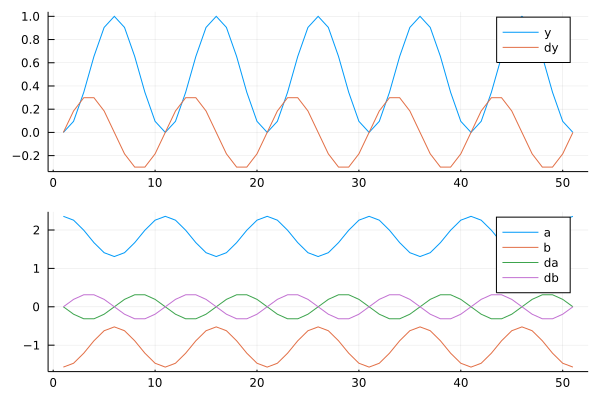

In [146]:
begin
    x = 0:50
    y = 0.5 .- 0.5*cos.((pi/5) .* x)
    t =  0:5
    println(t[6])
    a = 3*pi/4 .- pi/6*(1 .- cos.(pi/5 .* x))
    b = -pi/2 .+ pi/6*(1 .- cos.(pi/5 .* x))
    dy = 0.5*sin.(pi/5 .* x)*pi/5
    da = -((pi^2)/30)*sin.((pi/5) .* x)
    db = -da
    println(sum(da[1:6]))
    println(a[6] - a[1])
    p1 = plot(y, labels="y")
    plot!(dy, labels="dy")
    # plot(x)
    p2 = plot(a, labels="a")
    plot!(b, labels="b")
    # plot!(a+b)
    plot!(da, labels="da")
    plot!(db, labels="db")
    
    plot(p1, p2, layout = (2, 1), legend = true)
    
    
    # println(a[5])
end

In [148]:
function ref_traj(nlp, ymax)
    N = nlp.N
    xLen = length(nlp.xinds[1])
    uLen = length(nlp.uinds[1])
    
    xref = zeros(xLen, N)
    uref = zeros(uLen, N-1)
    
    ueq = equilibrium(nlp.model, nlp.x0, false, 7:8)
    for i = 1:(N-1)
        t = i - 1
        xref[1, i] = 0.0
        xref[2, i] = ymax - ymax*cos(t*pi/5)
        xref[3, i] = 3*pi/4 - pi/6*(1 - cos(t*pi/5))
        xref[4, i] = -pi/2 + pi/6*(1 - cos(t*pi/5))
        xref[5, i] = 0.0
        xref[6, i] = (ymax*pi/5)*sin(pi/5*t)
        xref[7, i] = -((pi^2)/30)*sin((pi/5)*t)
        xref[8, i] = ((pi^2)/30)*sin((pi/5)*t)
        uref[:, i] .= ueq
    end
    xref[:, end] .= nlp.xf
    return xref, uref
end

ref_traj (generic function with 1 method)